In [ ]:
from google.colab import files
from google.colab import drive
import os

# optional: mount Google Drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install python-resize-image

In [168]:
import pandas as pd
import numpy as np
import matplotlib as plt
from pylab import *
from PIL import Image
from resizeimage import resizeimage
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

# PCA

In [ ]:
%cd /content/gdrive/My Drive/Kaggle/melanoma/jpeg/train/

/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train


In [ ]:
malignant_df=train_csv[train_csv['benign_malignant']=='malignant'][:500]
benign_df=train_csv[train_csv['benign_malignant']=='benign'][:500]

In [ ]:
malignant_df_dev=train_csv[train_csv['benign_malignant']=='malignant'][500:]
benign_df_dev=train_csv[train_csv['benign_malignant']=='benign'][500:500+len(malignant_df_dev)]

In [189]:
train_labels_mal=malignant_df['benign_malignant'].tolist()
image_names_mal=malignant_df['image_name'].tolist()
train_labels_ben=benign_df['benign_malignant'].tolist()
image_names_ben=benign_df['image_name'].tolist()

train_labels_mal_dev=malignant_df_dev['benign_malignant'].tolist()
image_names_mal_dev=malignant_df_dev['image_name'].tolist()
train_labels_ben_dev=benign_df_dev['benign_malignant'].tolist()
image_names_ben_dev=benign_df_dev['image_name'].tolist()

In [190]:
def resize_images_to_arrays(image_names_pos, image_names_neg,
                            max_num_pos, max_num_neg,
                            rows, cols):
  '''Takes in lists of positive (malignant) and negative (benign) images,
  max number of positives and negatives desired in data and rows and columns to 
  resize images to and returns images and labels in list form.'''
  train_data=[]
  train_labels=[]
  num_mal=0
  num_benign=0
  for image in image_names_mal:
    try:
      im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image))
      im=array(im.resize((rows, cols)))
      train_data.append(im)
      train_labels.append(1)
      num_mal+=1
    except:
      pass
    if num_mal == max_num_pos:
      continue

  for image in image_names_ben:
      try:
        im = Image.open("/content/gdrive/.shortcut-targets-by-id/1qJ47SkRrR6gtmKvnBstwgxcG-abjnb3a/Kaggle/melanoma/jpeg/train/{}.jpg".format(image)) #"/content/gdrive/My Drive/Kaggle/melanoma/jpeg_compressed/q_60/train/{}.jpg"
        im=array(im.resize((rows, cols)))
        train_data.append(im)
        train_labels.append(0)
        num_benign+=1
      except:
        pass
      if num_mal == max_num_neg:
        continue
  return train_data, train_labels

In [191]:
train_data, train_labels = resize_images_to_arrays(image_names_mal, image_names_ben,
                            500, 500,
                            32, 32)

In [194]:
def Reshape_image_data_for_model(image_data, rows = 32, cols = 32):
  '''Takes rgb image data and returns a list of 1d arrays for each image.''' 
  data_array =array(image_data)
  X_data = data_array.reshape(data_array.shape[0], 32, 32, 3)
  X_data = X_data.astype('float32')

  X_data /= 255

  X_data_1d =[]
  for i in X_data:
    nsamples, nx, ny = i.shape
    d1_data = i.reshape((nsamples*nx*ny))
    X_data_1d.append(d1_data)

  return X_data_1d

In [195]:
X_train_pca = Reshape_image_data_for_model(train_data)

The first 1 components explain 0.628 percent of the total variance.
The first 2 components explain 0.722 percent of the total variance.
The first 3 components explain 0.767 percent of the total variance.
The first 4 components explain 0.793 percent of the total variance.
The first 5 components explain 0.816 percent of the total variance.
The first 10 components explain 0.888 percent of the total variance.
The first 20 components explain 0.934 percent of the total variance.
The first 30 components explain 0.950 percent of the total variance.
The first 40 components explain 0.959 percent of the total variance.
The first 50 components explain 0.966 percent of the total variance.


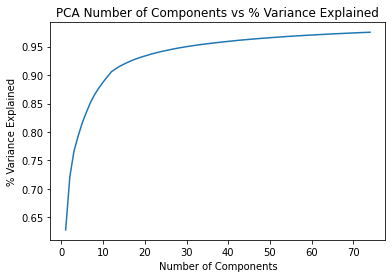

In [196]:
#Store values for different k means to explore and empty list to store explained variance
k_values = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50]
explained_variances = []

#Exploring explained variance for k values in list    
for k in k_values:
    pca = PCA(n_components=k)
    pca.fit(X_train_pca)
    print("The first {} components explain {:.3f} percent of the total variance."
          .format(k,pca.explained_variance_ratio_.sum()))
    
#Plotting explained variance for all possible principal components             
k_vals_to_plot = []
for k in range(1,75):
    pca = PCA(n_components=k)
    pca.fit(X_train_pca)
    explained_variances.append(pca.explained_variance_ratio_.sum())
    k_vals_to_plot.append(k)
    
#Plotting
plt.plot(k_vals_to_plot,explained_variances) 
plt.title("PCA Number of Components vs % Variance Explained") 
plt.xlabel("Number of Components") 
plt.ylabel("% Variance Explained")  
plt.show()

In [197]:
pca = PCA(n_components=50)
pca.fit(X_train_pca)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

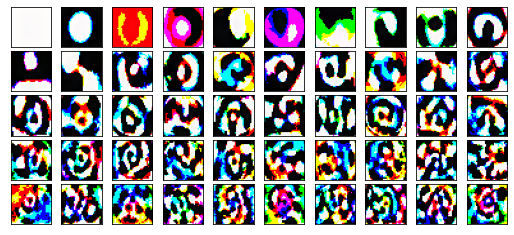

In [198]:
fig, axes = plt.subplots(5, 10, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
  ax.imshow((pca.components_[i]*255).reshape(32, 32,3).astype(np.uint8))